# È Deep Learning bro

In [51]:
import pandas as pd
import numpy as np
import os

path = ""
#df = pd.read_csv(path+"debug_set_614548.csv")
df = pd.read_csv(path+"debug_set_619439.csv")
df = df.rename(columns={"text": "X", "pop_level": "y"})

# drop duplicates observations, keeping the first occurrence
df = df.drop_duplicates(subset='X', keep='first')
print(df.shape)
display(df)

(9296, 5)


,X,likes,followers,popularity,y
0,i feel so shitty about my body today I want to...,1,343,0.846373,1
1,photo grow share giraffe prefer lunch radar tr...,0,7,0.690916,1
2,Kia ora!!! Welcome to Vietnam. \n\nYour local ...,0,51,0.536925,1
3,"In the 1950's, housewives were initially resis...",0,35,0.562277,1
4,i want you to make yourself your lunch and let...,3,277,1.742396,1
...,...,...,...,...,...
9408,# Manufacturers idle output and seek alternati...,0,2,0.809201,1
9409,I ate benachin for the first time yesterday fr...,1,6498,0.398438,0
9410,Idk how people could randomly take up somebody...,6,916,2.534738,2
9411,One of the things I committed to back in 2022 ...,0,2,0.809201,1


### Training Test Split

In [66]:
from sklearn.model_selection import train_test_split

y_col = 'y' ####
X_cols = df.columns
X_cols = X_cols.drop(y_col)

X_cols = X_cols.drop('likes')
X_cols = X_cols.drop('followers')
X_cols = X_cols.drop('popularity') ####

# split data
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:,X_cols], df.loc[:,y_col], test_size=0.2, random_state=0, shuffle=True)

# REVIEW THIS:
X_train = X_train['X']
X_test = X_test['X']

display(X_train)

2043    I have not been doing the best at dieting!!! T...
1629    Out with friends for lunch. Hubby of one, scro...
6510    I’m about to get Zya the chic she always wante...
1536    Homemade chicken sandwich for lunch, satisfyin...
3305    The plan is to become water this year buoy. \n...
                              ...                        
7979    Just made a smoothie with oat milk instead of ...
9342    Just sat thinking about how tasty my lunch was...
4905    todays reimbursement opportunities, send for o...
3282    like i'm literally going to a lunch on sunday ...
2748       I'll be back. Kain lunch and ligo na talaga. 🥹
Name: X, Length: 7436, dtype: object

In [53]:
# prepare tokenization
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# create a function to 
def tokenizer_snowballStemmer(text):
    return [stemmer.stem(word) for word in text.split()]

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

vectorizer = TfidfVectorizer(
    tokenizer = tokenizer_snowballStemmer,
    max_df=0.5,
    min_df=5,
    stop_words="english")

t0 = time()
vectorizer.fit(X_train)
X_train_1 = vectorizer.transform(X_train)
print(f"vectorization done in {time() - t0:.3f} s")

print(f"n_samples: {X_train_1.shape[0]}, n_features: {X_train_1.shape[1]}")
print(f"{X_train_1.nnz / np.prod(X_train_1.shape):.3f}")

#print("Vocabulary size using stemming: {}". format(len(count.vocabulary_)))
#print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))

# apply transformation to the tesr
X_test_1 = vectorizer.transform(X_test)
print("X_test: {}".format(X_test_1.shape))

feature_names = np.array(vectorizer.get_feature_names())
target_names = [0, 1 , 2]

display(target_names)

/Users/agustin/miniforge3/envs/dssc-deep/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/agustin/miniforge3/envs/dssc-deep/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi

vectorization done in 2.969 s
n_samples: 7436, n_features: 2426
0.003
X_test: (1860, 2426)


/Users/agustin/miniforge3/envs/dssc-deep/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[0, 1, 2]

Try only bag of word

In [68]:
# update the variables
X_train = X_train_1
X_test = X_test_1

### Modeling

Test a Random Forest first, to compare

In [69]:
from sklearn.ensemble import RandomForestClassifier

# fit a Random Forest model
clf_forest = RandomForestClassifier(n_estimators=100)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# plot CV results
scores = cross_val_score(clf_forest, X_train, y_train, cv=5, scoring='accuracy')
display("Cross Validation scores")
i=1
for a in scores:
    display("Accuracy cv=" + str(i) + ": " + str(round(a*100, 2)))
    i = i+1

display("Accuracy MEAN: "+str(round(scores.mean(),2)*100))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf_forest = clf_forest.fit(X_train, y_train) 

# results on test set
predictions = clf_forest.predict(X_test)
test_accuracy = accuracy_score(predictions, y_test)
display("Test set accuracy: " + str(round(test_accuracy*100, 2)))

display(confusion_matrix(predictions, y_test)) # display confusion matrix

'Cross Validation scores'

'Accuracy cv=1: 52.55'

'Accuracy cv=2: 51.58'

'Accuracy cv=3: 52.93'

'Accuracy cv=4: 52.25'

'Accuracy cv=5: 51.31'

'Accuracy MEAN: 52.0'

'Test set accuracy: 48.55'

array([[221, 245,  56],
       [425, 677, 221],
       [  3,   7,   5]])

Use deep learning

In [70]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_train)  # fit does nothing.
transformer

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train = X_train.toarray()
X_test = X_test.toarray()

In [71]:
import tensorflow as tf

input_shape = [X_train.shape[1]]

model = tf.keras.Sequential([
 
    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=input_shape),
    #tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                155328    
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 155,393
Trainable params: 155,393
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(optimizer='adam', loss='mae') 


losses = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   batch_size=256,
                   epochs=20,
                   )

Epoch 1/20
 7/30 [======>.......................] - ETA: 0s - loss: 0.7759

2023-01-14 01:22:29.174610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 13ms/step - loss: 0.7360 - val_loss: 0.6712
Epoch 2/20
 9/30 [========>.....................] - ETA: 0s - loss: 0.6311

2023-01-14 01:22:29.599451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 8ms/step - loss: 0.5747 - val_loss: 0.5370
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.5054 - val_loss: 0.5307
Epoch 4/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4828 - val_loss: 0.5325
Epoch 5/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4657 - val_loss: 0.5364
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4490 - val_loss: 0.5422
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4323 - val_loss: 0.5497
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.4162 - val_loss: 0.5562
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.3999 - val_loss: 0.5629
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.3864 - val_loss: 0.5677
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.3720 - val_loss: 0.5742
Epoch 12/20
30/30 [==========

<AxesSubplot: >

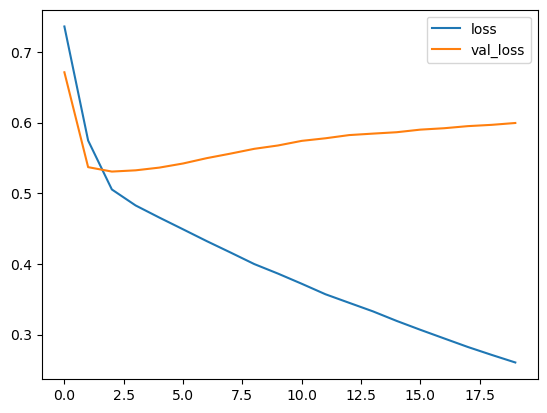

In [73]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()

# test_results = {}

test_results['model'] = model.evaluate(
    X_test, y_test, verbose=0)

print(f" Accuracy: {test_results}")